In [1]:
#Plot 5 - Fraction of 

In [2]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
#import dask
#import daskdataframe as dd
import matplotlib.pyplot as plt
import glob
import netCDF4 as nc
import zarr
import nc_time_axis
import xskillscore as xs
import cartopy as cart
#%run data_handler.ipynb
#np.set_printoptions(threshold=np.inf)
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from scipy.special import erfinv, erf
import numbers

In [3]:
########## CONUS ############
#CONUS lat-lon
ctop    = 50.0 # north lat
cleft   = (360-124.7844079)%360 # west long
cright  = (360-66.9513812)%360# east long
cbottom =  24.7433195 # south lat
################################
#Europe lat-lon
eutop     = 60.0
eubottom  = 35.0
euleft    = (360-10.0)%360
euright   = 50
# # #Bengaluru:
LAT        = 12.9716
LON        = 77.5946
################################
cesm2_path       = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
cvals            = '/global/scratch/users/harsha/LENS/cesm2/cvals/'
cvals1           = '/global/scratch/users/harsha/LENS/cesm2/tmax_mem'
era5_noleap_path = '/global/scratch/users/harsha/ERA5/tasmax/era5_noleap_1950_2021.zarr'
##############################
print(cleft,cright)
print(euleft,euright)

235.21559209999998 293.0486188
350.0 50


In [4]:
# #Chicago
chic_LAT        = 41.8781
chic_LON        = (360-87.6298)%360
print(chic_LON)

272.3702


In [5]:
def gauss_quantile(mean,std,quantile):
    #quantile must be a real number netween 0 and 1
    qvalue = mean + std * np.sqrt(2) * erfinv(2*quantile-1)
    return qvalue
    

In [6]:
def global_annual_rmse(arr_err, dim):
      #Compute spatially weighted global mean of square error
      # and then compute annual rmse #g = global, a= annual
        arr_err_sq            = arr_err**2
        weights               = np.cos(np.deg2rad(arr_err_sq.lat))
        weights.name          = "weights"
        arr_serror_weighted   = arr_err_sq.weighted(weights)
        arr_serror_gmean      = arr_serror_weighted.mean({'lat','lon'})
        ####
        arr_gamse             = arr_serror_gmean.mean(dim)
        arr_garmse            = np.sqrt(arr_gamse)
        
        return arr_garmse

In [7]:
job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
#job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=lr_lowprio','--account=ac_cumulus']
cluster = dask_jobqueue.SLURMCluster(queue="cf1", cores=10, walltime='6:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(4)

In [8]:
cluster

In [9]:
def to_daily(ds):
    year = ds.time.dt.year
    day = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), day=("time", day.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "day")).unstack("time")  

In [10]:
def stacker(x):
    #Assumes that x has dimensions year and member
    x = x.stack(ym=('year','member'),create_index=False)
    return x
def stacker2(x):
    #Assumes that x has dimensions year and member
    x = x.stack(mtime=('year','member'),create_index=False)
    return x

In [11]:
def stack_roll(ds,roll_len,stride_len):
    #Assumes that ds has dimensions year and member
    ds_stack   = stacker(ds)
    ds_roll    = ds_stack.rolling(ym=roll_len, center=True).construct('index', stride=stride_len)
    
    return ds_roll   

In [12]:
pi_year0 = '1850'
pi_year1 = '1879'
ic_year0 = '2071'
ic_year1 = '2100'
#doy      = 211 # day_of_year
#date     = 'Jul30'

In [13]:
%%time
ds_ssp  = xr.open_mfdataset(cesm2_path+'ssp370_cesm2tmax.zarr',engine='zarr')
ds_hist = xr.open_mfdataset(cesm2_path+'bhist_cesm2tmax.zarr',engine='zarr')

CPU times: user 688 ms, sys: 200 ms, total: 887 ms
Wall time: 3.02 s


In [14]:
%%time
#t-temp, nw - no-warming, w-warming, hw = historical warming, g=global
tgw    = ds_ssp.TREFHTMX
         #.sel(lat=slice(bottom,top))
         #.sel(lon=slice(left,right))
tgnw   = ds_hist.TREFHTMX.sel(time=slice(pi_year0,pi_year1))
         #.sel(lon=slice(left,right)).sel(lat=slice(bottom,top))
tghw   = ds_hist.TREFHTMX
         #.sel(lat=slice(bottom,top))
         #.sel(lon=slice(left,right))
#tgnw

CPU times: user 127 ms, sys: 97 µs, total: 127 ms
Wall time: 125 ms


In [15]:
%%time
tgw_trim     = tgw.drop_isel({'time':-1}).sel(time=slice(ic_year0,ic_year1)) #Drop Jan 1, 2101 data
tghw_trim    = tghw.drop_isel({'time':-1}).sel(time=slice(pi_year0,pi_year1)) #Drop an extra copy of Jan 1, 2015 data
tgmw         = xr.concat([tghw_trim,tgw_trim],dim='time')
tgmw         = tgmw.chunk({'time':900,'lat':20,'lon':30,'member':100})   
tgmw

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]

CPU times: user 763 ms, sys: 21.7 ms, total: 784 ms
Wall time: 776 ms


,Array,Chunk
Bytes,451.13 GiB,205.99 MiB
Shape,"(21900, 192, 288, 100)","(900, 20, 30, 100)"
Count,57502 Tasks,2500 Chunks
Type,float32,numpy.ndarray


In [16]:
quants = np.arange(0.0,1.01,0.01)

In [17]:
############# Open previously computed global, annual RMSEs #####################

In [18]:
%%time
qgmw_grmsepath  = cvals+'qgmw_grmse'+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmc_grmsepath  = cvals+'qgmc_grmse'+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmsc_grmsepath = cvals+'qgmsc_grmse'+'_'+pi_year0+'_'+ic_year1+'.zarr'
##########################
qgmw_grmse   = xr.open_zarr(qgmw_grmsepath)
qgmc_grmse   = xr.open_zarr(qgmc_grmsepath)
qgmsc_grmse  = xr.open_zarr(qgmsc_grmsepath)
qgmw_grmse   = qgmw_grmse.TREFHTMX
qgmc_grmse   = qgmc_grmse.TREFHTMX
qgmsc_grmse  = qgmsc_grmse.TREFHTMX

CPU times: user 13.1 ms, sys: 3.31 ms, total: 16.4 ms
Wall time: 147 ms


In [19]:
# %%time
# error_redn = qgmsc_grmse.integrate('quantile')/qgmc_grmse.integrate('quantile')
# error_redn.values

In [20]:
########## Check CLT ###########

In [21]:
%%time
tgmw_d  = to_daily(tgmw)
tgmw_d0 = tgmw_d.sel(year=slice(1850,1879))
tgmw_d1 = tgmw_d.sel(year=slice(ic_year0,ic_year1))
tgmw_d1 = tgmw_d1.chunk({'day':30})
#tgmw_d1

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/dataset.py:4880: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._unstack_full_reindex(


CPU times: user 455 ms, sys: 16.4 ms, total: 471 ms
Wall time: 467 ms


In [22]:
%%time
#Stack member and year into one dimension- 'ym'. Then, roll over this dimension with stride = N_mem.
#This works because of the way xarray stacks two dimensions. window_len =30. 
#I have called the 'window' dimension 'index'.
quants             = np.arange(0,1.01,0.01)
N_mem              = 100
window_len         = 30
#r = roll, ndrop = drop NANs
tgmw_eocroll       = stack_roll(tgmw_d1,N_mem*window_len,N_mem)
tgmw_piroll        = stack_roll(tgmw_d0,N_mem*window_len,N_mem)
#########
tgmw_eocroll0      = tgmw_eocroll.sel(ym=[15])
tgmw_piroll0       = tgmw_piroll.sel(ym=[15])
tgmw_piroll0

CPU times: user 402 ms, sys: 14.6 ms, total: 416 ms
Wall time: 412 ms


/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/variable.py:1722: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._stack_once(dims, new_dim)


<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288, day: 365, ym: 1, index: 3000)>
dask.array<getitem, shape=(192, 288, 365, 1, 3000), dtype=float32, chunksize=(20, 30, 365, 1, 3000), chunktype=numpy.ndarray>
Coordinates:
    year     (ym) int64 1865
  * day      (day) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member   (ym) int64 0
Dimensions without coordinates: ym, index
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [23]:
tgmw_eocmroll = tgmw_eocroll0.mean('index')
tgmw_eocsroll = tgmw_eocroll0.std('index')
qgmw_eocroll  = tgmw_eocroll0.quantile(quants,dim='index',skipna=False)
######################
tgmw_pimroll = tgmw_piroll0.mean('index')
tgmw_pisroll = tgmw_piroll0.std('index')
qgmw_piroll  = tgmw_piroll0.quantile(quants,dim='index',skipna=False)

In [24]:
# Generate normal distributions using means and standard deviations
index = np.arange(3000) 

gaussians_eoc = xr.apply_ufunc(
    np.random.normal,
    tgmw_eocmroll,
    tgmw_eocsroll,
    input_core_dims=[[], []],
    output_core_dims=[['index']],
    vectorize=True,
    output_dtypes=[float],
    kwargs={'size': 3000},
     output_sizes={'index': 3000},
    dask='parallelized'
)

/tmp/ipykernel_15701/8299844.py:4: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  gaussians_eoc = xr.apply_ufunc(


In [25]:
# Generate normal distributions using means and standard deviations
index = np.arange(3000) 
gaussians_pi = xr.apply_ufunc(
    np.random.normal,
    tgmw_pimroll,
    tgmw_pisroll,
    input_core_dims=[[], []],
    output_core_dims=[['index']],
    vectorize=True,
    output_dtypes=[float],
    kwargs={'size': 3000},
     output_sizes={'index': 3000},
    dask='parallelized'
)

/tmp/ipykernel_15701/1575987664.py:3: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  gaussians_pi = xr.apply_ufunc(


In [26]:
qgauss_eoc = gaussians_eoc.quantile(quants,dim='index',skipna=False)
qgauss_pi  = gaussians_pi.quantile(quants,dim='index',skipna=False)

In [27]:
qgmw_gauss_eoc_diff  = qgauss_eoc - qgmw_eocroll
qgmw_gauss_pi_diff   = qgauss_pi  - qgmw_piroll

In [28]:
###### Save ######
qgmw_gauss_eoc_diffpath     = cvals+'qgmw_gauss_eoc_diff'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgmw_gauss_pi_diffpath      = cvals+'qgmw_gauss_pi_diff'+'_'+pi_year0+'_'+pi_year1+'.zarr'
# qgmw_gauss_pi_diff.to_dataset().to_zarr(qgmw_gauss_pi_diffpath,mode='w')
# qgmw_gauss_eoc_diff.to_dataset().to_zarr(qgmw_gauss_eoc_diffpath,mode='w')

In [29]:
# qgmw_gauss_eoc_diff   = xr.open_zarr(qgmw_gauss_eoc_diff)
# qgmw_gauss_pi_diff    = xr.open_zarr(qgmw_gauss_pi_diff)
# qgmw_gauss_eoc_diff   = qgmw_gauss_eoc_diff.TREFHTMX
# qgmw_gauss_pi_diff    = qgmw_gauss_pi_diff.TREFHTMX

In [30]:
qgmw_gauss_eoc_grmse         = global_annual_rmse(qgmw_gauss_eoc_diff,dim='day') 
qgmw_gauss_pi_grmse          = global_annual_rmse(qgmw_gauss_pi_diff,dim='day') 
qgmw_gauss_pi_grmse 

<xarray.DataArray 'TREFHTMX' (quantile: 101, ym: 1)>
dask.array<sqrt, shape=(101, 1), dtype=float64, chunksize=(101, 1), chunktype=numpy.ndarray>
Coordinates:
    year      (ym) int64 1865
    member    (ym) int64 0
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0
Dimensions without coordinates: ym

In [31]:
# qgmw_gesq                   = qgmw_gauss_diff**2
# qgmw_gauss_serror_weighted  = qgmw_gesq.weighted(weights)
# qgmw_gauss_serror_gmean     = qgmw_gauss_serror_weighted.mean({'lat','lon'})
# ################################################

In [32]:
%%time
qgmw_gauss_eoc_grmsepath = cvals+'qgmw_gauss_eoc_grmse'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qgmw_gauss_pi_grmsepath  = cvals+'qgmw_gauss_pi_grmse'+'_'+pi_year0+'_'+pi_year1+'.zarr'
##########################
###qgmw_gauss_eoc_grmse.to_dataset().to_zarr(qgmw_gauss_eoc_grmsepath,mode='w')

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 14.5 µs


In [33]:
%%time
##qgmw_gauss_pi_grmse.to_dataset().to_zarr(qgmw_gauss_pi_grmsepath,mode='w')

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 11 µs


In [34]:
qgmw_gauss_eoc_grmse = xr.open_zarr(qgmw_gauss_eoc_grmsepath)
qgmw_gauss_pi_grmse  = xr.open_zarr(qgmw_gauss_pi_grmsepath)
qgmw_gauss_eoc_grmse = qgmw_gauss_eoc_grmse.TREFHTMX
qgmw_gauss_pi_grmse  = qgmw_gauss_pi_grmse.TREFHTMX

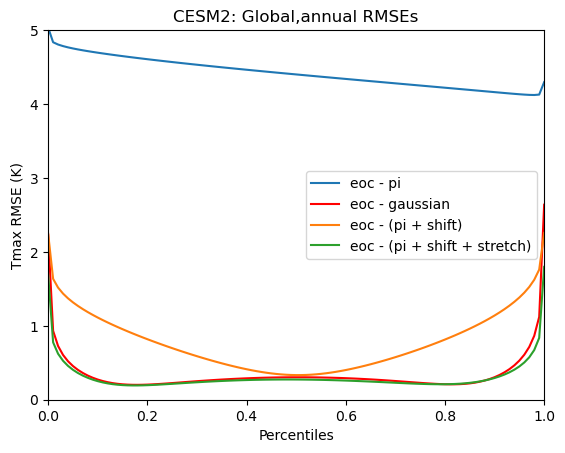

CPU times: user 1.86 s, sys: 242 ms, total: 2.1 s
Wall time: 23 s


In [35]:
%%time
plt.plot(quants,qgmw_grmse,label='eoc - pi',color='tab:blue')
plt.plot(quants,qgmw_gauss_eoc_grmse,label='eoc - gaussian',color='red')
plt.plot(quants,qgmc_grmse,label='eoc - (pi + shift)',color='tab:orange')
plt.plot(quants,qgmsc_grmse,label='eoc - (pi + shift + stretch)',color='tab:green')
plt.legend(loc='center right')
plt.title('CESM2: Global,annual RMSEs')
plt.ylabel('Tmax RMSE (K)')
plt.xlabel('Percentiles')
plt.xlim(0.0,1.0)
plt.ylim(0.0,5.0)
plt.show()

In [36]:
################### DJF RMSEs for CONUS and Europe ###############

In [37]:
months = [12,1,2]
season0 = 'djf'

In [38]:
%%time
#ds = daily, season
tgmw_season     = tgmw.sel(time=tgmw.time.dt.month.isin(months))
tgmw_dseason    = to_daily(tgmw_season)
tgmw_pids       = tgmw_dseason.sel(year=slice(pi_year0,pi_year1))
tgmw_eocds      = tgmw_dseason.sel(year=slice(ic_year0,ic_year1))
tgmw_eocds    

CPU times: user 144 ms, sys: 3.9 ms, total: 148 ms
Wall time: 146 ms


/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


,Array,Chunk
Bytes,55.62 GiB,61.80 MiB
Shape,"(192, 288, 100, 30, 90)","(20, 30, 100, 3, 90)"
Count,73602 Tasks,1300 Chunks
Type,float32,numpy.ndarray


In [39]:
%%time
quants             = np.arange(0,1.01,0.01)
N_mem              = 100
window_len         = 30
#r = roll, ndrop = drop NANs
# tgmw_spiroll        = stack_roll(tgmw_pids,N_mem*window_len,N_mem)
tgmw_seocroll       = stack_roll(tgmw_eocds,N_mem*window_len,N_mem)
#########
# tgmw_spiroll0       = tgmw_spiroll.sel(ym=[15])
tgmw_seocroll0      = tgmw_seocroll.sel(ym=[15])
tgmw_seocroll0

CPU times: user 32.3 ms, sys: 5.05 ms, total: 37.3 ms
Wall time: 35.2 ms


<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288, day: 90, ym: 1, index: 3000)>
dask.array<getitem, shape=(192, 288, 90, 1, 3000), dtype=float32, chunksize=(20, 30, 90, 1, 3000), chunktype=numpy.ndarray>
Coordinates:
    year     (ym) int64 2086
  * day      (day) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member   (ym) int64 0
Dimensions without coordinates: ym, index
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [40]:
%%time
# tgmw_spimroll = tgmw_spiroll0.mean('index')
# tgmw_spisroll = tgmw_spiroll0.std('index')
# # qgmw_spiroll  = tgmw_spiroll0.quantile(quants,dim='index',skipna=False)
# ##################################
tgmw_seocmroll = tgmw_seocroll0.mean('index')
tgmw_seocsroll = tgmw_seocroll0.std('index')
qgmw_seocroll  = tgmw_seocroll0.quantile(quants,dim='index',skipna=False)
qgmw_seocroll

CPU times: user 11.7 ms, sys: 1.97 ms, total: 13.6 ms
Wall time: 13.3 ms


<xarray.DataArray 'TREFHTMX' (quantile: 101, lat: 192, lon: 288, day: 90, ym: 1)>
dask.array<transpose, shape=(101, 192, 288, 90, 1), dtype=float64, chunksize=(101, 20, 30, 90, 1), chunktype=numpy.ndarray>
Coordinates:
    year      (ym) int64 2086
  * day       (day) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member    (ym) int64 0
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0
Dimensions without coordinates: ym

In [41]:
#########################
gaussians_seoc = xr.apply_ufunc(
    np.random.normal,
    tgmw_seocmroll,
    tgmw_seocsroll,
    input_core_dims=[[], []],
    output_core_dims=[['index']],
    vectorize=True,
    output_dtypes=[float],
    kwargs={'size': 3000},
     output_sizes={'index': 3000},
    dask='parallelized'
)
gaussians_seoc

/tmp/ipykernel_15701/1002913868.py:2: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  gaussians_seoc = xr.apply_ufunc(


<xarray.DataArray 'TREFHTMX' (lat: 192, lon: 288, day: 90, ym: 1, index: 3000)>
dask.array<transpose, shape=(192, 288, 90, 1, 3000), dtype=float64, chunksize=(20, 30, 90, 1, 3000), chunktype=numpy.ndarray>
Coordinates:
    year     (ym) int64 2086
  * day      (day) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member   (ym) int64 0
Dimensions without coordinates: ym, index

In [42]:
%%time
# qgauss_spi  = gaussians_spi.quantile(quants,dim='index',skipna=False)
qgauss_seoc = gaussians_seoc.quantile(quants,dim='index',skipna=False)

CPU times: user 5.53 ms, sys: 0 ns, total: 5.53 ms
Wall time: 5.45 ms


In [43]:
#qgauss_seoc.sel(lat=LAT,lon=LON,method='nearest').sel(day=1).plot()

Exception ignored in: <generator object sync.<locals>.f at 0x2b60fe6d99e0>
Traceback (most recent call last):
  File "/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/distributed/utils.py", line 378, in f
    result = yield future
KeyboardInterrupt: 

KeyboardInterrupt



In [44]:
# qgmw_gauss_spidiff  = qgauss_spi - qgmw_spiroll
qgmw_gauss_seocdiff = qgauss_seoc - qgmw_seocroll

In [45]:
qgmw_seoc_gesq        = qgmw_gauss_seocdiff**2
qcmw_seoc_gesq        = qgmw_seoc_gesq.sel(lat=slice(cbottom,ctop)).sel(lon=slice(cleft,cright))
qcmw_seoc_gesq

<xarray.DataArray 'TREFHTMX' (quantile: 101, lat: 27, lon: 46, day: 90, ym: 1)>
dask.array<getitem, shape=(101, 27, 46, 90, 1), dtype=float64, chunksize=(101, 18, 25, 90, 1), chunktype=numpy.ndarray>
Coordinates:
    year      (ym) int64 2086
  * day       (day) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365
  * lat       (lat) float64 24.97 25.92 26.86 27.8 ... 46.65 47.59 48.53 49.48
  * lon       (lon) float64 236.2 237.5 238.8 240.0 ... 288.8 290.0 291.2 292.5
    member    (ym) int64 0
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0
Dimensions without coordinates: ym

In [46]:
############ CLT for conus ################

In [47]:
%%time
########### Save the absolute errors ############
qgmw_djf_diffpath      = cvals+'qgmw_djf_diff'+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmw_djf_reldiff1path  = cvals+'qgmw_djf_reldiff1'+'_'+pi_year0+'_'+ic_year1+'.zarr'
qgmw_djf_reldiff2path  = cvals+'qgmw_djf_reldiff2'+'_'+pi_year0+'_'+ic_year1+'.zarr'
##### Open ########
qgmw_djf_diff     = xr.open_zarr(qgmw_djf_diffpath)
qgmw_djf_reldiff1 = xr.open_zarr(qgmw_djf_reldiff1path)
qgmw_djf_reldiff2 = xr.open_zarr(qgmw_djf_reldiff2path)
qgmw_djf_diff     = qgmw_djf_diff.TREFHTMX
qgmw_djf_reldiff1 = qgmw_djf_reldiff1.TREFHTMX
qgmw_djf_reldiff2 = qgmw_djf_reldiff2.TREFHTMX

CPU times: user 57.5 ms, sys: 13.9 ms, total: 71.3 ms
Wall time: 517 ms


In [49]:
%%time
##### CONUS only #############
qcmw_djf_diff       = qgmw_djf_diff.sel(lat=slice(cbottom,ctop)).sel(lon=slice(cleft,cright))
qcmc_djf_reldiff1   = qgmw_djf_reldiff1.sel(lat=slice(cbottom,ctop)).sel(lon=slice(cleft,cright))
qcmsc_djf_reldiff2  = qgmw_djf_reldiff2.sel(lat=slice(cbottom,ctop)).sel(lon=slice(cleft,cright))

############ Delete below this #################
# qgmw_djf_esq  = qgmw_djf_diff**2
# qgmc_djf_esq  = qgmw_djf_reldiff1**2
# qgmsc_djf_esq = qgmw_djf_reldiff2**2

###############################
# conus_weights      = np.cos(np.deg2rad(qcmw_djf_esq.lat))
# conus_weights.name = "conus_weights"
# #w = weighted
# qcmw_djf_esw   = qcmw_djf_esq.weighted(conus_weights)
# qcmc_djf_esw   = qcmc_djf_esq.weighted(conus_weights)
# qcmsc_djf_esw  = qcmsc_djf_esq.weighted(conus_weights)

CPU times: user 7.79 ms, sys: 2.06 ms, total: 9.86 ms
Wall time: 8.18 ms


In [ ]:
####### Check where Gaussian does better than shift+ stretch ###########

In [50]:
%%time
qcmw_eoc_gauss_msc_sqdiff  = qcmw_seoc_gesq - qgmsc_djf_esq
#qcmw_eoc_gauss_msc_sqdiff0 = qcmw_eoc_gauss_msc_sqdiff.where(qcmw_eoc_gauss_msc_sqdiff <0,drop=True).squeeze()
qcmw_eoc_gauss_msc_sqdiff

NameError: name 'qgmsc_djf_esq' is not defined

In [ ]:
############################################## RMSEs #####################

In [54]:
# qcmw_djf_rmse   = global_annual_rmse(qcmw_djf_diff, 'day') 
# qcmc_djf_rmse   = global_annual_rmse(qcmw_djf_reldiff1, 'day') 
# qcmsc_djf_rmse  = global_annual_rmse(qcmw_djf_reldiff2, 'day') 
# qcmsc_djf_rmse
############### Delete below ###################
# qcmw_djf_cmean  = qcmw_djf_esw.mean({'lat','lon'})
# qcmc_djf_cmean  = qcmc_djf_esw.mean({'lat','lon'})
# qcmsc_djf_cmean = qcmsc_djf_esw.mean({'lat','lon'})
# #######################################
# qcmw_djf_cmse   = qcmw_djf_cmean.mean('day')
# qcmc_djf_cmse   = qcmc_djf_cmean.mean('day')
# qcmsc_djf_cmse  = qcmsc_djf_cmean.mean('day')
# ########################################
# qcmw_djf_crmse  = np.sqrt(qcmw_djf_cmse)
# qcmc_djf_crmse  = np.sqrt(qcmc_djf_cmse)
# qcmsc_djf_crmse = np.sqrt(qcmsc_djf_cmse)

In [55]:
%%time
qcmw_djf_crmsepath  = cvals+'qcmw_djf_crmse'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qcmc_djf_crmsepath  = cvals+'qcmc_djf_crmse'+'_'+ic_year0+'_'+ic_year1+'.zarr'
qcmsc_djf_crmsepath = cvals+'qcmsc_djf_crmse'+'_'+ic_year0+'_'+ic_year1+'.zarr'
####### Save ################
# qcmw_djf_crmse.to_dataset().to_zarr(qcmw_djf_crmsepath,mode='w')
# qcmc_djf_crmse.to_dataset().to_zarr(qcmc_djf_crmsepath,mode='w')
# qcmsc_djf_crmse.to_dataset().to_zarr(qcmsc_djf_crmsepath,mode='w')
########## Open ##################
qcmw_djf_crmse  = xr.open_zarr(qcmw_djf_crmsepath)
qcmc_djf_crmse  = xr.open_zarr(qcmc_djf_crmsepath)
qcmsc_djf_crmse = xr.open_zarr(qcmsc_djf_crmsepath)
qcmw_djf_crmse  = qcmw_djf_crmse.TREFHTMX
qcmc_djf_crmse  = qcmc_djf_crmse.TREFHTMX
qcmsc_djf_crmse = qcmsc_djf_crmse.TREFHTMX

CPU times: user 21.7 ms, sys: 3.07 ms, total: 24.7 ms
Wall time: 221 ms


In [57]:
# %%time
# qcmw_gauss_eocwserror       = qcmw_seoc_gesq.weighted(conus_weights)
# qcmw_gserror_eoc_cmean      = qcmw_gauss_eocwserror.mean({'lat','lon'})
# #
# qcmw_gauss_eoc_cmse         = qcmw_gserror_eoc_cmean.mean('day')
# qcmw_gauss_eoc_crmse        = np.sqrt(qcmw_gauss_eoc_cmse)
# ######################################
# qcmw_gauss_eoc_crmse 

In [ ]:
%%time
############################
qcmw_gauss_eoc_crmsepath = cvals+'qcmw_gauss_eoc_crmse'+'_'+ic_year0+'_'+ic_year1+'.zarr'
#qcmw_gauss_eoc_crmse.to_dataset().to_zarr(qcmw_gauss_eoc_crmsepath,mode='w')

In [ ]:
%%time
qcmw_gauss_eoc_crmse = xr.open_zarr(qcmw_gauss_eoc_crmsepath)
qcmw_gauss_eoc_crmse = qcmw_gauss_eoc_crmse.TREFHTMX

In [ ]:
%%time
plt.plot(quants,qcmw_djf_crmse,label='eoc - pi',color='tab:blue')
plt.plot(quants,qcmw_gauss_eoc_crmse,label='eoc - gaussian',color='red')
plt.plot(quants,qcmc_djf_crmse,label='eoc - (pi + shift)',color='tab:orange')
plt.plot(quants,qcmsc_djf_crmse,label='eoc - (pi + shift + stretch)',color='tab:green')
plt.legend(loc='center right')
plt.title('CESM2: DJF, conus RMSEs')
plt.ylabel('Tmax RMSE (K)')
plt.xlabel('Percentiles')
plt.show()

In [ ]:
############### Gaussian approximation for ERA5 ##################

In [58]:
tera = xr.open_zarr(era5_noleap_path)
tera = tera.tasmax
tera = tera.chunk({'day':10})
tera

,Array,Chunk
Bytes,4.87 GiB,18.99 MiB
Shape,"(105, 237, 72, 365)","(105, 237, 10, 10)"
Count,601 Tasks,296 Chunks
Type,float64,numpy.ndarray


In [72]:
tera_roll    = tera.rolling(year=30, center=True).construct('index', stride=1)
tera_roll    = tera_roll.sel(year=slice(1965,2007))
tera_roll    = tera_roll.sel(year=[1965,2007])

In [61]:
%%time
tera_sroll = tera_roll.std('index')
tera_mroll = tera_roll.mean('index')
tera_mroll = tera_mroll.chunk({'year':43})
tera_sroll = tera_sroll.chunk({'year':43})
############################################
era_srollpath = cvals+'era5_sroll_1950_2021.zarr'
era_mrollpath = cvals+'era5_mroll_1950_2021.zarr'
###########################################
# tera_mroll.to_dataset().to_zarr(era_mrollpath,mode='w')
# tera_sroll.to_dataset().to_zarr(era_srollpath,mode='w')

CPU times: user 28.7 s, sys: 1.33 s, total: 30.1 s
Wall time: 2min 6s


In [68]:
tera_sroll = xr.open_zarr(era_srollpath)
tera_mroll = xr.open_zarr(era_mrollpath)
tera_mroll = tera_mroll.tasmax
tera_sroll = tera_sroll.tasmax
tera_sroll = tera_sroll.sel(year=[1965,2007])
tera_mroll = tera_mroll.sel(year=[1965,2007])
tera_mroll 

,Array,Chunk
Bytes,138.60 MiB,3.80 MiB
Shape,"(105, 237, 2, 365)","(105, 237, 2, 10)"
Count,75 Tasks,37 Chunks
Type,float64,numpy.ndarray


In [70]:
gauss_era = xr.apply_ufunc(
                        np.random.normal,
                        tera_mroll,
                        tera_sroll,
                        input_core_dims=[[], []],
                        output_core_dims=[['index']],
                        vectorize=True,
                        output_dtypes=[float],
                        kwargs={'size': 3000},
                        output_sizes={'index': 3000},
                        dask='parallelized'
)
gauss_era

/tmp/ipykernel_15701/304725521.py:1: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  gauss_era = xr.apply_ufunc(


,Array,Chunk
Bytes,4.06 GiB,113.91 MiB
Shape,"(105, 237, 2, 365, 30)","(105, 237, 2, 10, 30)"
Count,261 Tasks,37 Chunks
Type,float64,numpy.ndarray


In [73]:
qera        = tera_roll.quantile(quants,dim='index',skipna=False)
qgauss_era  = gauss_era.quantile(quants,dim='index',skipna=False)
qera

,Array,Chunk
Bytes,13.67 GiB,191.76 MiB
Shape,"(101, 105, 237, 2, 365)","(101, 105, 237, 1, 10)"
Count,2586 Tasks,74 Chunks
Type,float64,numpy.ndarray


In [ ]:
qera_err    = qera - qgauss_era